# Attrition curves for various demographics

In [6]:
# Imports

# Usual imports
import os
import sys
import time
import datetime
import json
import csv
import glob
import pprint
import importlib
from tqdm import tqdm
from collections import Counter

import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import itertools
import time
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'serif','serif':['FreeSerif']})
rc('text', usetex=False)
from matplotlib import rc
sns.set_palette("Set2")

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, style
from matplotlib.ticker import FixedLocator
from matplotlib.dates import DateFormatter

import seaborn as sns
from IPython.display import Image
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

# For regression
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Custom modules
sys.path.insert(0, '../')
import psychometry
import parser
import utils

# Some edits to matplotlib
# https://towardsdatascience.com/simple-ways-to-improve-your-matplotlib-b64eebccfd5
# https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08
#plt.rcParams.update({'font.size': 20})
style.use('seaborn-talk') #sets the size of the charts

# This is the color of sh.rice.edu/covid-sense website background. It is NOT white
bg_color = (0.96862745, 0.96862745, 0.96862745)

# Convert a timestamp into time string
d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

#saveroot = '/home/vishwanath/Dropbox/Apps/Overleaf/CovidSense Analysis/figures/'
saveroot = 'D:/Dropbox/Apps/Overleaf/CovidSense Analysis/figures/'

In [7]:
# Load database
dbname = '../data/db_snapshot.json'

with open(dbname, 'rb') as readfile:
    db = json.load(readfile)

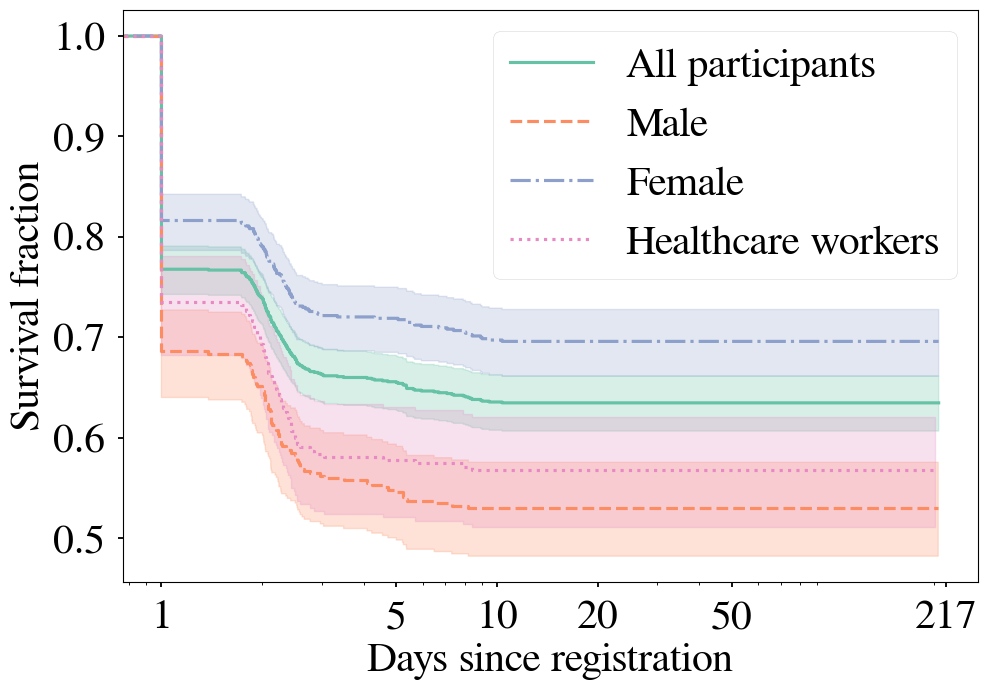

In [8]:
# Attrition curve
attrition_thres = 0.05

epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()

today = datetime.date.today().strftime('%d/%m/%Y')
epoch2 = int(time.mktime(datetime.datetime.strptime(today, '%d/%m/%Y').timetuple()))

ntimes = int(np.floor((epoch2-epoch1)/(60*60*24)))

nparticipants = len(db)

start_day = np.zeros(nparticipants)
duration = np.zeros(nparticipants)
genders = np.zeros(nparticipants)
healthcare = np.zeros(nparticipants)
age = np.zeros(nparticipants)
countries = list()

for idx, key in enumerate(db):
    participant = db[key]

    timestamps = 1000*np.array(participant['timestamps'])

    if participant['gender'] == 'male':
        genders[idx] = 1
    elif participant['gender'] == 'female':
        genders[idx] = 2

    if participant['healthcare_worker']:
        healthcare[idx] = 1
        
    age[idx] = participant['age']
    countries.append(participant['country'])

    mintime = min(timestamps)
    maxtime = max(timestamps)

    start_day[idx] = (mintime/1000 - epoch1)/(60*60*24)
    duration[idx] = (maxtime-mintime)/(1000*60*60*24) + 1

#variances = np.var(response_image[:, :, 1], axis=1)
variances = duration/(ntimes-start_day)
indices = np.argsort(variances)

# Do a KaplanMeierFitter
observed = (duration/(ntimes - start_day) < attrition_thres)

kmf_all = KaplanMeierFitter()
kmf_male = KaplanMeierFitter()
kmf_female = KaplanMeierFitter()
kmf_healthcare = KaplanMeierFitter()

kmf_all.fit(duration, event_observed=observed)
kmf_male.fit(duration[genders==1], event_observed=observed[genders==1])
kmf_female.fit(duration[genders==2], event_observed=observed[genders==2])
kmf_healthcare.fit(duration[healthcare==1], event_observed=observed[healthcare==1])

fig = plt.figure(dpi=100, figsize=(10, 7))
fontsize = 30
kmf_all.plot(label='All participants')
kmf_male.plot(label='Male', linestyle='--')
kmf_female.plot(label='Female', linestyle='-.')
kmf_healthcare.plot(label='Healthcare workers', linestyle=':')
plt.xscale('log')
plt.xticks([1, 5, 10, 20, 50, ntimes], labels=['1', '5', '10', '20', '50', str(ntimes)], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Days since registration', fontsize=fontsize)
plt.ylabel('Survival fraction', fontsize=fontsize)
plt.legend(fontsize=30)
plt.tight_layout()
plt.savefig('%s/attrition_all.pdf'%saveroot)
plt.show()


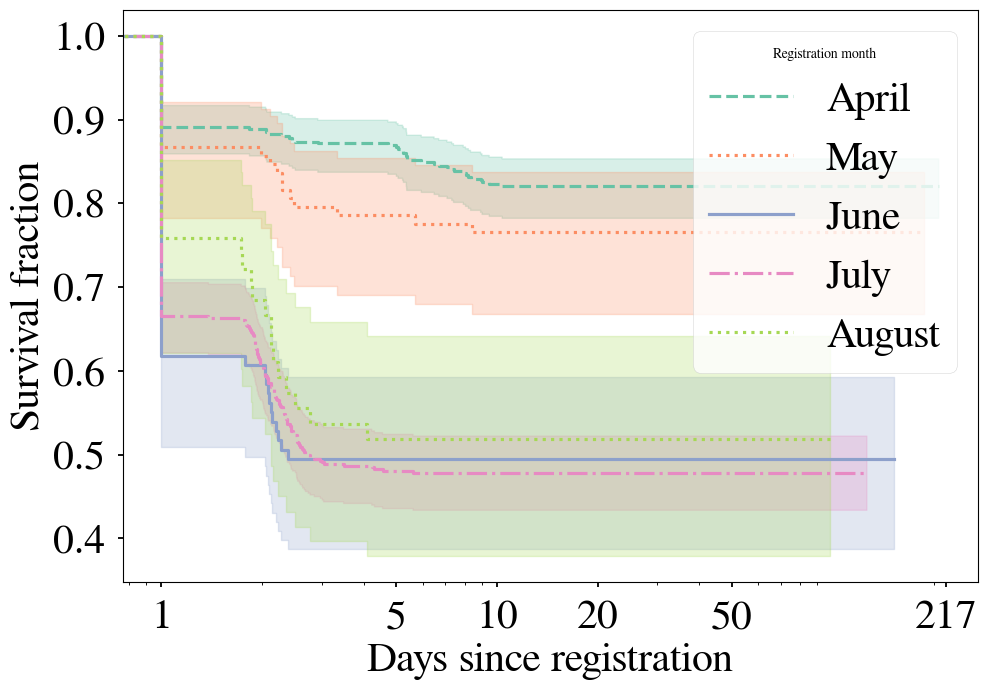

In [9]:
## Plot by month
fig = plt.figure(dpi=100, figsize=(10, 7))

months = ['April', 'May', 'June', 'July', 'August']
linestyles = ['--', ':', '-', '-.', ':', '-.']
for nmonth in range(5):
    kmf = KaplanMeierFitter()
    kmf.fit(duration[start_day//30 == nmonth],
            event_observed=observed[start_day//30 == nmonth])
    
    kmf.plot(label=months[nmonth],
             linestyle=linestyles[nmonth])
    
plt.xscale('log')
plt.legend(title='Registration month', fontsize=fontsize, loc='upper right')
plt.xticks([1, 5, 10, 20, 50, ntimes], labels=['1', '5', '10', '20', '50', str(ntimes)], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Days since registration', fontsize=fontsize)
plt.ylabel('Survival fraction', fontsize=fontsize)
plt.tight_layout()
plt.savefig('%s/attrition_month.pdf'%saveroot)
plt.show()


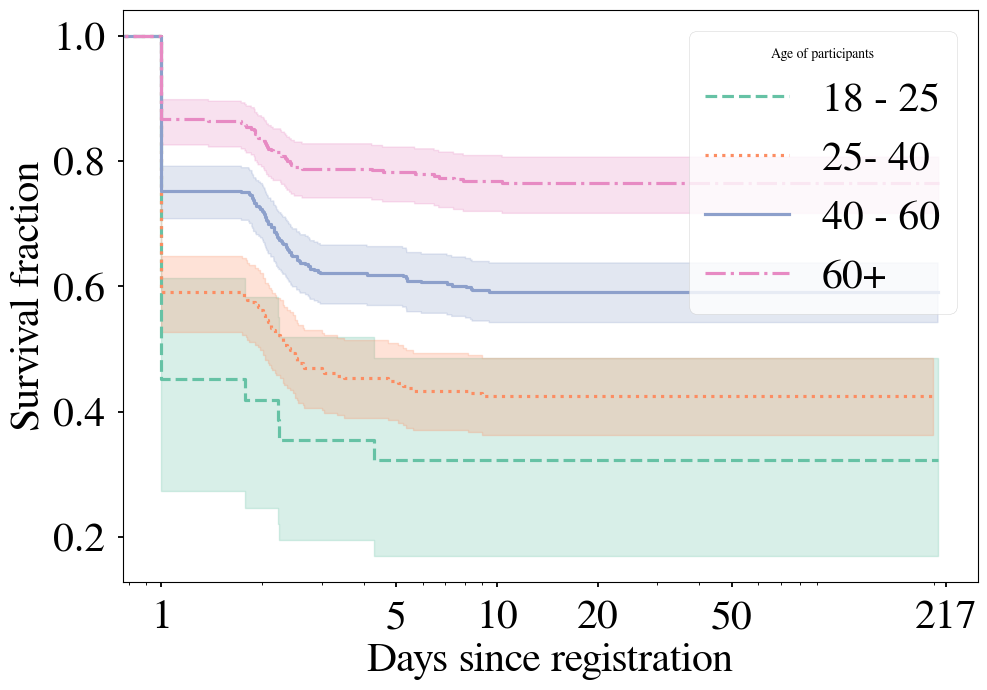

In [10]:
## Plot by age
fig = plt.figure(dpi=100, figsize=(10, 7))

age_brackets = [0, 18, 25, 40, 60, 100]
age_bracket_labels = ['18 - 25', '25- 40', '40 - 60', '60+']
linestyles = ['--', ':', '-', '-.', ':', '-.']

for idx in range(1, len(age_brackets)-1):
    kmf = KaplanMeierFitter()
    indices = np.where((age > age_brackets[idx-1])*(age <= age_brackets[idx]))
    kmf.fit(duration[indices],
            event_observed=observed[indices])
    
    kmf.plot(label=age_bracket_labels[idx-1],
             linestyle=linestyles[idx-1])
    
plt.xscale('log')
plt.legend(title='Age of participants', fontsize=fontsize, loc='upper right')
plt.xticks([1, 5, 10, 20, 50, ntimes], labels=['1', '5', '10', '20', '50', str(ntimes)], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Days since registration', fontsize=fontsize)
plt.ylabel('Survival fraction', fontsize=fontsize)
plt.tight_layout()
plt.savefig('%s/attrition_age.pdf'%saveroot)
plt.show()

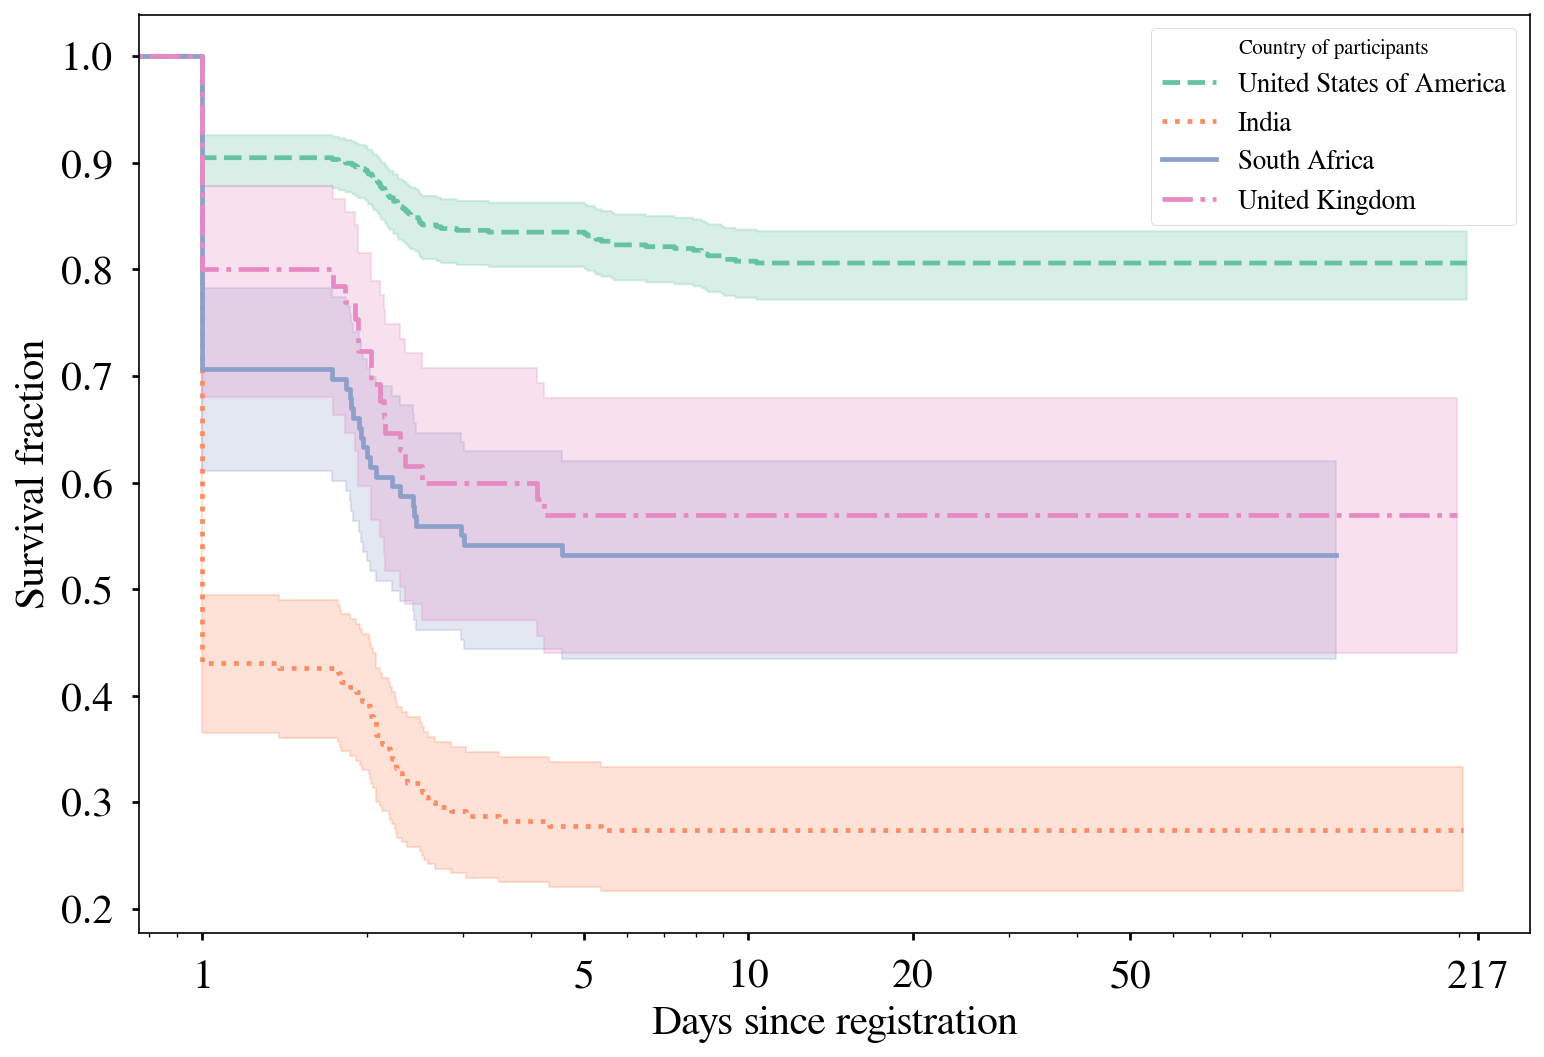

In [11]:
## Plot by country
fig = plt.figure(dpi=150)

country_names = ['United States of America', 'India', 'South Africa', 'United Kingdom']
countries = np.array(countries)
linestyles = ['--', ':', '-', '-.', ':', '-.']

for idx in range(len(country_names)):
    kmf = KaplanMeierFitter()
    kmf.fit(duration[countries==country_names[idx]],
            event_observed=observed[countries==country_names[idx]])
    
    kmf.plot(label=country_names[idx],
             linestyle=linestyles[idx])
    
plt.xscale('log')
plt.legend(title='Country of participants')
plt.xticks([1, 5, 10, 20, 50, ntimes], labels=['1', '5', '10', '20', '50', str(ntimes)], fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Days since registration', fontsize=20)
plt.ylabel('Survival fraction', fontsize=20)
plt.tight_layout()
plt.show()

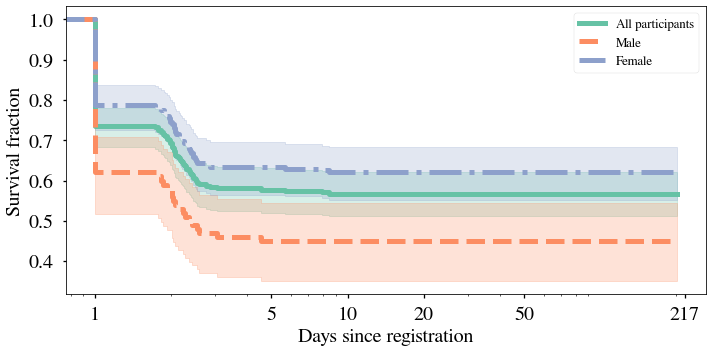

In [12]:
# Isolate responses for healthcare workers
kmf_all = KaplanMeierFitter()
kmf_male = KaplanMeierFitter()
kmf_female = KaplanMeierFitter()

kmf_all.fit(duration[healthcare==1], event_observed=observed[(healthcare==1)])
kmf_male.fit(duration[(healthcare==1)*(genders==1)], event_observed=observed[(healthcare==1)*(genders==1)])
kmf_female.fit(duration[(healthcare==1)*(genders==2)], event_observed=observed[(healthcare==1)*(genders==2)])

fig = plt.figure(figsize=(10, 5))
kmf_all.plot(label='All participants', linewidth=5.0)
kmf_male.plot(label='Male', linestyle='--', linewidth=5.0)
kmf_female.plot(label='Female', linestyle='-.', linewidth=5.0)

plt.xscale('log')
plt.xticks([1, 5, 10, 20, 50, ntimes], labels=['1', '5', '10', '20', '50', str(ntimes)], fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Days since registration', fontsize=20)
plt.ylabel('Survival fraction', fontsize=20)
plt.tight_layout()
plt.savefig('../../paper/healthcare_attrition.pdf')
plt.show()
